In [ ]:
os._exit(0)

In [1]:
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
import wandb
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/ritish/prog/ML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    'noise_dim': 100,
    'img_size': 128,
    'channels': 3,
    'batch_size': 512,
    'lr': 2e-4,
    'dropout': 0.3,
    'seed': 100,
    'betas': (0.5, 0.999),
}

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=True):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.transform = transform
        
        # Define Albumentations transform if provided
        if self.transform:
            self.albumentations_transform = A.Compose([
                A.Resize(config['img_size'], config['img_size'], interpolation=cv2.INTER_LINEAR),
                A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                ToTensorV2()
            ])
        else:
            self.albumentations_transform = None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        
        # Use cv2 to load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Apply Albumentations transform if specified
        if self.albumentations_transform:
            image = self.albumentations_transform(image=image)['image']
        
        return image
    
celeba_dataset = CelebADataset(root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba', transform=True)

In [5]:
batch_size = config['batch_size']
train_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

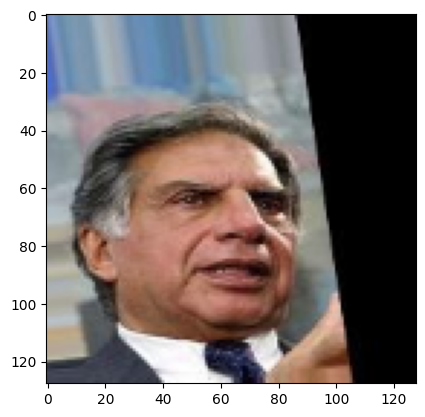

In [6]:
img = next(iter(train_loader))
plt.imshow(img[0].permute(1,2,0)*.5+.5)

In [7]:
wandb.finish()

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("wandb"))
wandb.init(
    project='GAN_celeb_faces',
    entity='ritishtest1',

    config=config
    )

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std
    
    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.std
            return x + noise
        return x

class gen_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, batch_norm=True, activation='relu', noise_std=0.1, leaky_relu_slope=0.2):
        super().__init__()
        self.net = nn.Sequential(
            GaussianNoise(noise_std),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            #nn.GELU() if activation == 'relu' else nn.Tanh(),
            nn.LeakyReLU(leaky_relu_slope, inplace=True) if activation == 'relu' else nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)
    
class disc_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, act='leaky_relu', batch_norm=True, leaky_relu_slope=0.2, noise_std=0.1):
        super().__init__()
        self.net = nn.Sequential(
            GaussianNoise(noise_std),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
            nn.LeakyReLU(leaky_relu_slope, inplace=True) if act=='leaky_relu' else nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

# class Generator(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config
#         self.net = nn.Sequential(            
#             gen_block(config['noise_dim'], 512, 4, 1, 0),
#             gen_block(512, 256, 4, 2, 1),
#             gen_block(256, 128, 4, 2, 1),
#             gen_block(128, 64, 4, 2, 1),
#             gen_block(64, 64, 4, 2, 1),
#             gen_block(64, config['channels'], 4, 2, 1, bias=False, activation='tanh'),
#         )
#         self.apply(weights_init)

#     def forward(self, x):
#         return self.net(x)

class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.MLP = nn.Sequential(
            nn.Linear(config['noise_dim'], 1024*4*4, bias=False),
            nn.BatchNorm1d(1024*4*4),
            nn.GELU(),
        )
        self.net = nn.Sequential(
            gen_block(1024, 512, 4, 2, 1),
            gen_block(512, 256, 4, 2, 1),
            gen_block(256, 128, 4, 2, 1),
            gen_block(128, 64, 4, 2, 1),
            gen_block(64, 3, 4, 2, 1, activation='tanh')
        )
        
        self.apply(weights_init)
        
    def forward(self, noise):
        noise = self.MLP(noise).view(-1, 1024, 4, 4)
        return self.net(noise)

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.net = nn.Sequential(
            disc_block(config['channels'], 32, 4, 2, 1, bias=False),     # 128x128 -> 64x64
            disc_block(32, 64, 4, 2, 1, bias=False),                     # 64x64 -> 32x32
            disc_block(64, 128, 4, 2, 1, bias=False),                    # 32x32 -> 16x16
            disc_block(128, 256, 4, 2, 1, bias=False),                   # 16x16 -> 8x8
            disc_block(256, 512, 4, 2, 1, bias=False),                   # 8x8 -> 4x4
            #disc_block(512, 1, 4, 1, 0, bias=False, act='sigmoid', batch_norm=False),
            GaussianNoise(0.1),
            nn.Flatten(),
            nn.Linear(512*4*4, 1),
            nn.Sigmoid(),
        )

        self.apply(weights_init)

    def forward(self, x):
        return self.net(x)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(config['seed'])
G = Generator(config).to(device)
D = Discriminator(config).to(device)

# Initialize fixed noise and labels
fixed_noise = torch.randn(32, config['noise_dim'], device=device)

In [6]:
# Load model checkpoints
G.load_state_dict(torch.load('generator.safetensors'))
D.load_state_dict(torch.load('discriminator.safetensors'))

<All keys matched successfully>

In [23]:
config['lr'] = 1e-4
criterion = nn.BCELoss()        # -a*torch.log(D(x)) - (1-a)*torch.log(1-D(G(z)))
optimizer_G = optim.Adam(G.parameters(), lr=config['lr'], betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=config['lr'], betas=(0.5, 0.999))

In [24]:
# Function to create a batch of 32 images from noise and log them to wandb
def log_images(G, noise):
    with torch.no_grad():
        fake = G(noise)*.5+.5
        wandb.log({'images': [wandb.Image(img) for img in fake]}, commit=False)

In [25]:
config['batch_size'] = 1024
train_loader = DataLoader(celeba_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

In [ ]:
G.train()
D.train()
gc.collect()
torch.cuda.empty_cache()
for epoch in range(20):
    for i, (img) in enumerate(train_loader):
        # Label smoothing
        #real_label = random.uniform(0.8, 0.9)
        #fake_label = random.uniform(0.1, 0.2)
        
        real_label = 0.9  # Was 0.8/0.2 at the starting of the training
        fake_label = 0.1
        
        # Move data to device
        img = img.to(device)
        batch_size = img.size(0)
        
        # Train discriminator with real images (Since batch norm won't work well with both real and fake images, we train them separately)
        D.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        d_out = D(img).view(-1)
        loss_real = criterion(d_out, label)

        # Calculate gradients for real inputs
        loss_real.backward()
        D_x = d_out.mean().item()

        # Train discriminator with fake images
        noise = torch.randn(batch_size, config['noise_dim']).to(device)
        fake_img = G(noise)
        label.fill_(fake_label)
        d_out = D(fake_img.detach()).view(-1)      # Only update the disciminator, gradients shouldn't pass through the generator
        loss_fake = criterion(d_out, label)

        # Calculate gradients for fake inputs
        loss_fake.backward()
        D_G_z1 = d_out.mean().item()
        d_loss = loss_real + loss_fake
        optimizer_D.step()

        # Train generator
        G.zero_grad()
        label.fill_(1.0)
        d_out = D(fake_img).view(-1)           # Update the generator after discriminator update
        gen_loss = criterion(d_out, label)     # Just maximize log(D(G(z))
        gen_loss.backward()
        D_G_z2 = d_out.mean().item()
        optimizer_G.step()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Step {i}/{len(train_loader)}, D(x): {D_x:.4f}, D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}, Loss D: {d_loss.item():.4f}, Loss G: {gen_loss.item():.4f}")
            wandb.log({'D(x)': D_x, 'D(G(z))_1': D_G_z1, 'D(G(z))_2': D_G_z2, 'Loss D': d_loss.item(), 'Loss G': gen_loss.item(), 'D_LR': optimizer_D.param_groups[0]['lr'], 'G_LR': optimizer_G.param_groups[0]['lr']})
            gc.collect()
            torch.cuda.empty_cache()

            if (i % 100 == 0):
                G.eval()
                log_images(G, fixed_noise)
                print("Images logged to wandb")
                G.train()

Epoch 1, Step 0/198, D(x): 0.5430, D(G(z)): 0.2503/0.6010, Loss D: 1.0821, Loss G: 0.5305
Images logged to wandb
Epoch 1, Step 10/198, D(x): 0.6710, D(G(z)): 0.3792/0.2179, Loss D: 1.0418, Loss G: 1.5960


In [8]:
# Create a 4x4 grid of images
def create_grid(G, figsize=(8, 8)):
    G.eval()
    with torch.no_grad():
        noise = torch.randn(16, config['noise_dim']).to(device)
        fake = G(noise)
        fig, ax = plt.subplots(4, 4, figsize=figsize)
        for i in range(4):
            for j in range(4):
                ax[i, j].imshow(fake[i*4+j].cpu().detach().permute(1, 2, 0)*.5+.5)
                ax[i, j].axis('off')
        plt.show()

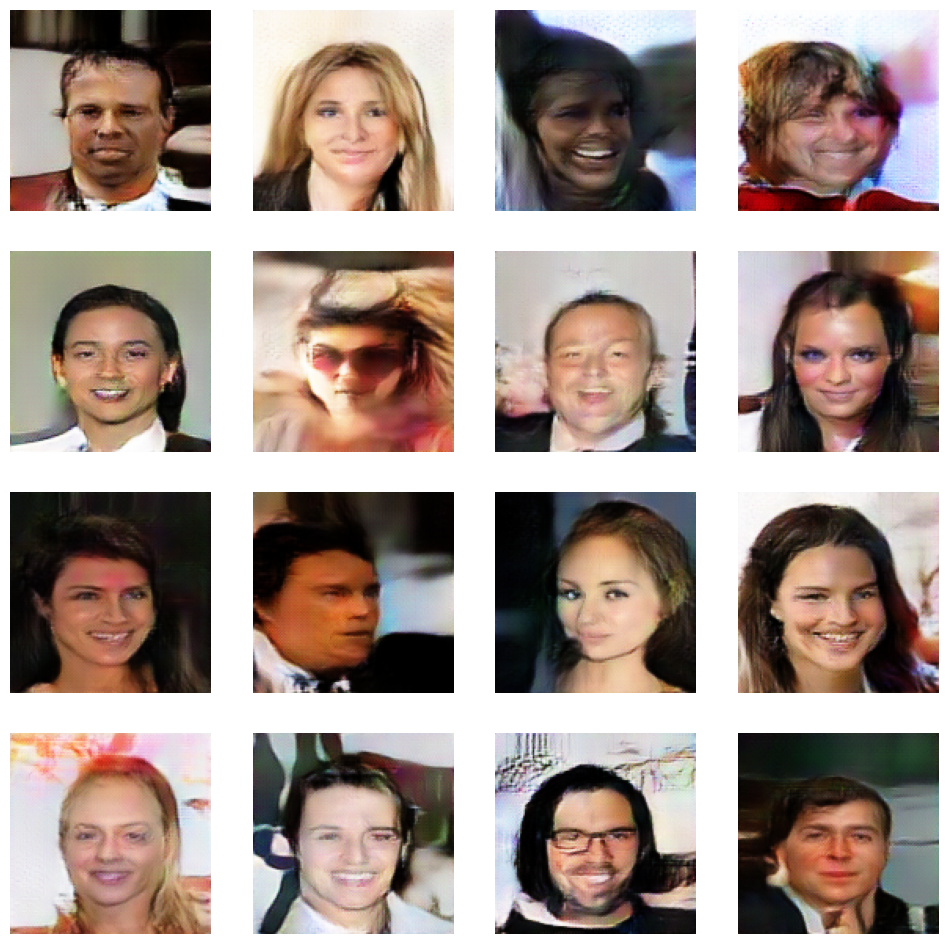

In [12]:
create_grid(G, (12,12))

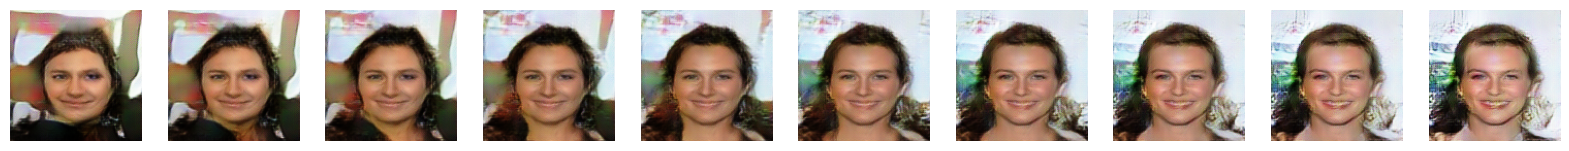

In [253]:
# Interpolate between 2 noise sources
def interpolate(G, noise1, noise2, steps=5):
    G.eval()
    with torch.no_grad():
        fig, ax = plt.subplots(1, steps, figsize=(20, 20))
        for i in range(steps):
            noise = noise1 + (noise2 - noise1) * i / (steps-1)
            fake = G(noise)
            ax[i].imshow(fake[0].cpu().detach().permute(1, 2, 0)*.5+.5)
            ax[i].axis('off')
        plt.show()

noise1 = torch.randn(1, config['noise_dim']).to(device)
noise2 = torch.randn(1, config['noise_dim']).to(device)
interpolate(G, noise1, noise2, steps=10)

In [22]:
# torch.save(G.state_dict(), 'generator.safetensors')
# torch.save(D.state_dict(), 'discriminator.safetensors')

In [551]:
# Now train a encoder model to encode the images to noise for the GAN generator as a decoder
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.net = nn.Sequential(
            disc_block(config['channels'], 32, 4, 2, 1, bias=False),     # 128x128 -> 64x64
            disc_block(32, 64, 4, 2, 1, bias=False),                     # 64x64 -> 32x32
            disc_block(64, 128, 4, 2, 1, bias=False),                    # 32x32 -> 16x16
            disc_block(128, 256, 4, 2, 1, bias=False),                   # 16x16 -> 8x8
            disc_block(256, 512, 4, 2, 1, bias=False),                   # 8x8 -> 4x4
            GaussianNoise(0.1),
            nn.Flatten(),
            nn.Linear(512*4*4, config['noise_dim']),
            nn.BatchNorm1d(config['noise_dim']),                         # Normalize the noise
        )

        self.apply(weights_init)

    def forward(self, x):
        return self.net(x)

In [595]:
# Freeze the generator network first
G.eval()
D.eval()
for param in G.parameters():
    param.requires_grad = False
for param in D.parameters():
    param.requires_grad = False

# Create encoder
E = Encoder(config).to(device)

In [596]:
optimizer_E = optim.Adam(E.parameters(), lr=3e-4, betas=(0.5, 0.999))

In [597]:
num_steps = 100
for i in range(num_steps):
    E.train()
    # Create noise and pass through the generator to create fake images. Pass these images through the encoder to get the noise back
    E.zero_grad()
    noise = torch.randn(config['batch_size'], config['noise_dim']).to(device)
    fake = G(noise)
    noise_pred = E(fake)
    loss = F.mse_loss(noise_pred, noise)
    loss.backward()
    optimizer_E.step()

    if i % 10 == 0:
        print(f"Step {i}/{num_steps}, Loss: {loss.item():.4f}")

Step 0/100, Loss: 1.9885
Step 10/100, Loss: 1.1722
Step 20/100, Loss: 0.9867
Step 30/100, Loss: 0.8793
Step 40/100, Loss: 0.8042
Step 50/100, Loss: 0.7419
Step 60/100, Loss: 0.7094
Step 70/100, Loss: 0.6807
Step 80/100, Loss: 0.6531
Step 90/100, Loss: 0.6209


0.9998840093612671

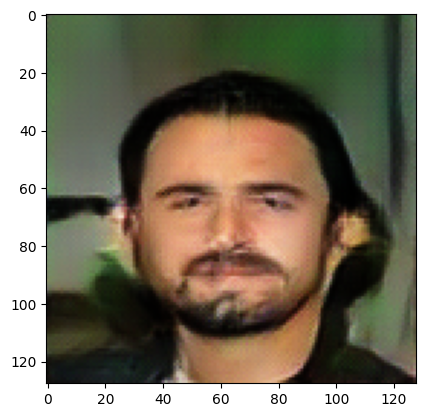

In [1112]:
n1 = torch.randn(1, config['noise_dim']).to(device)
fake = G(n1)
plt.imshow(fake[0].cpu().detach().permute(1, 2, 0)*.5+.5)

# Print discriminator score
D(fake).item()

In [969]:
noise = torch.randn(1, config['noise_dim']).to(device)

Text(0.5, 1.0, 'Interpolated Image')

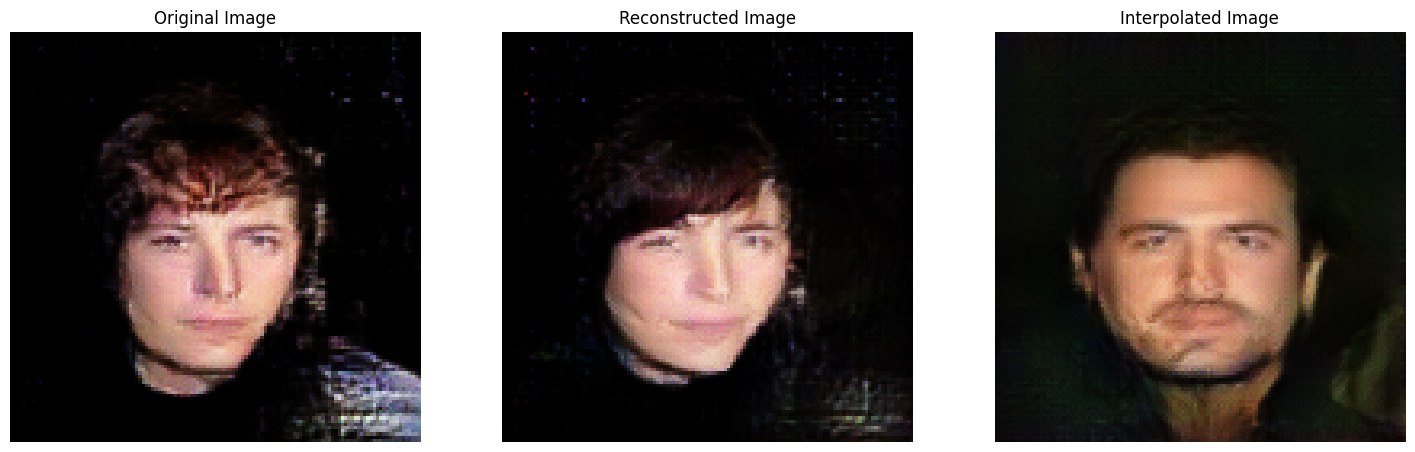

In [1121]:
# Test the encoder
E.eval()
G.eval()

noise = torch.randn(1, config['noise_dim']).to(device)
fake = G(noise)

noise_pred = E(fake)
fake_pred_noise = G(noise_pred)

t = 0.4

fake_pred_1 = G(t * noise_pred + (1-t) * n1)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(fake[0].cpu().detach().permute(1, 2, 0)*.5+.5)
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(fake_pred_noise[0].cpu().detach().permute(1, 2, 0)*.5+.5)
ax[1].axis('off')
ax[1].set_title('Reconstructed Image')
ax[2].imshow(fake_pred_1[0].cpu().detach().permute(1, 2, 0)*.5+.5)
ax[2].axis('off')
ax[2].set_title('Interpolated Image')